# Machine Learning

Machine learning is a statistical approach in which a computer learns to complete a task
by iterating over example data, known as training data. A simple form of
machine learning is linear regression, in which an algorithm
identifies the optimal combination of model coefficients
using a feature matrix (X) and output vector (y).

Here we give a brief introduction to machine learning, covering a range of topics including
supervised learning, splitting training and testing data, and feature importance.

## Setup

To follow along with this tutorial you can create a new virtual environment and install
the necessary requirements by entering

```bash
pip install -r requirements.txt
```

## Predicting sgRNA Activity

In this example you will predict the activity of sgRNAs from flow tiling screens
published in [Doench et al., 2014](https://www.nature.com/articles/nbt.3026#MOESM5).

Before getting started, we'll import all of our required packages and data.

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import gpplot
import seaborn as sns
import shap

In [2]:
tiling_data = pd.read_csv('data/external/Doench2014_S7.csv')
tiling_data

,Sequence,Expanded Sequence,Position,Type,Gene,Transcript,Strand,Gene % Rank,sgRNA Score
0,AAGAGAGACAGTACATGCCC,ATTGAAGAGAGACAGTACATGCCCTGGGAG,17237,CDS,CD13,ENST00000300060,sense,0.990110,0.081214
1,GGAGCCCACCGAGTACCTGG,TGGTGGAGCCCACCGAGTACCTGGTGGTGC,8790,CDS,CD13,ENST00000300060,sense,0.982418,0.524962
2,TAGAGTGGTGGAATGACCTG,ACCATAGAGTGGTGGAATGACCTGTGGCTG,10926,CDS,CD13,ENST00000300060,sense,0.975824,0.517795
3,GTTCATGATGTCCCGCACGG,AGCGGTTCATGATGTCCCGCACGGTGGTGG,13319,CDS,CD13,ENST00000300060,antisense,0.975824,0.470029
4,TGGCTTACCAAGTTCCAGGT,CAGCTGGCTTACCAAGTTCCAGGTGGGCTC,10992,CDS,CD13,ENST00000300060,antisense,0.972527,0.264375
...,...,...,...,...,...,...,...,...,...
1836,GCGGGAGCGGTACGTGTGCT,TGACGCGGGAGCGGTACGTGTGCTCGGGTA,3911,CDS,Thy1,ENSMUST00000114840,antisense,0.064516,0.038515
1837,GGCTGGTCACCTTCTGCCCT,GTCAGGCTGGTCACCTTCTGCCCTCGGGAC,3750,CDS,Thy1,ENSMUST00000114840,antisense,0.048387,0.101506
1838,AGGAGAGCGACGCTGATGGC,GAGCAGGAGAGCGACGCTGATGGCTGGGTT,3111,CDS,Thy1,ENSMUST00000114840,antisense,0.032258,0.076339
1839,GCACGTGCTTCCTCTTCTCT,GAGAGCACGTGCTTCCTCTTCTCTCGGGTC,3867,CDS,Thy1,ENSMUST00000114840,antisense,0.016129,0.124656


### Building the feature matrix and output vector

Since most machine learning models cannot read text, we will encode the
nucleotide sequences into a numeric matrix.

In [3]:
context_seqs = tiling_data['Expanded Sequence']
context_seqs

0       ATTGAAGAGAGACAGTACATGCCCTGGGAG
1       TGGTGGAGCCCACCGAGTACCTGGTGGTGC
2       ACCATAGAGTGGTGGAATGACCTGTGGCTG
3       AGCGGTTCATGATGTCCCGCACGGTGGTGG
4       CAGCTGGCTTACCAAGTTCCAGGTGGGCTC
                     ...              
1836    TGACGCGGGAGCGGTACGTGTGCTCGGGTA
1837    GTCAGGCTGGTCACCTTCTGCCCTCGGGAC
1838    GAGCAGGAGAGCGACGCTGATGGCTGGGTT
1839    GAGAGCACGTGCTTCCTCTTCTCTCGGGTC
1840    AAGGCACTGCTGTGCCAGTCTTGCAGGTGT
Name: Expanded Sequence, Length: 1841, dtype: object

In [4]:
expanded_seqs = pd.DataFrame(context_seqs.apply(lambda s: pd.Series(list(s))))
expanded_seqs

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,A,T,T,G,A,A,G,A,G,A,...,G,C,C,C,T,G,G,G,A,G
1,T,G,G,T,G,G,A,G,C,C,...,C,T,G,G,T,G,G,T,G,C
2,A,C,C,A,T,A,G,A,G,T,...,C,C,T,G,T,G,G,C,T,G
3,A,G,C,G,G,T,T,C,A,T,...,A,C,G,G,T,G,G,T,G,G
4,C,A,G,C,T,G,G,C,T,T,...,A,G,G,T,G,G,G,C,T,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,T,G,A,C,G,C,G,G,G,A,...,T,G,C,T,C,G,G,G,T,A
1837,G,T,C,A,G,G,C,T,G,G,...,C,C,C,T,C,G,G,G,A,C
1838,G,A,G,C,A,G,G,A,G,A,...,T,G,G,C,T,G,G,G,T,T
1839,G,A,G,A,G,C,A,C,G,T,...,C,T,C,T,C,G,G,G,T,C


In [5]:
X = pd.get_dummies(expanded_seqs)
X

,0_A,0_C,0_G,0_T,1_A,1_C,1_G,1_T,2_A,2_C,...,27_G,27_T,28_A,28_C,28_G,28_T,29_A,29_C,29_G,29_T
0,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,0,0,0,1,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1837,0,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,0,0
1838,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1839,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [6]:
y = tiling_data['Gene % Rank']
y

0       0.990110
1       0.982418
2       0.975824
3       0.975824
4       0.972527
          ...   
1836    0.064516
1837    0.048387
1838    0.032258
1839    0.016129
1840    0.000000
Name: Gene % Rank, Length: 1841, dtype: float64

### Splitting training and testing data

To determine whether the trained model can generalize to unseen data, we will hold out two genes for testing purposes.
When a model does not generalize to unseen data this is known as overfitting. We will randomly pick Cd5 and CD33 as our testing
genes, holding out about 20% of the dataset for testing.

In [7]:
tiling_data['Gene'].value_counts()

CD13    455
Cd45    277
CD15    273
Cd5     239
H2-K    169
CD33    154
Cd43    138
Cd28     74
Thy1     62
Name: Gene, dtype: int64

In [8]:
testing_genes = ['Cd5', 'CD33']
training_indeces = ~tiling_data['Gene'].isin(testing_genes)
testing_indeces = tiling_data['Gene'].isin(testing_genes)
testing_indeces.sum()/(tiling_data.shape[0])

0.21347093970668116

In [9]:
X_train = X[training_indeces]
X_test = X[testing_indeces]
y_train = y[training_indeces]
y_test = y[testing_indeces]

### Training a Gradient Boosted Regression Tree

A gradient boosted regression tree is a model class
which combines the predictions of a series of weaker learners known as decision trees.
Each decision tree identifies the features which are best at predicting the output variable.
Models which are trained to predict an output variable are known as
supervised learning approaches, whereas unsupervised approaches do not
consider an output variable.

We will use the `GradientBoostingRegressor` class from the python
package [scikit-learn](https://scikit-learn.org/stable/) as our model.
Scikit-learn is programmed with a consistent syntax,
so you can set `model` to scikit-learn regressor class, such as
[`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lasso#sklearn.linear_model.LassoCV)
to test out a different model.

Scikit-learn's implementation of gradient boosted regression works well for datasets with fewer than
10,000 samples, but for more than 10,000 samples a different package,
[LightGBM](https://lightgbm.readthedocs.io/en/latest/), tends to be faster.

In [10]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

### Testing model predictions

You can use the held out test data to evaluate the trained model.

In [11]:
predictions = model.predict(X_test)

The model has a moderate predictive ability for the held out genes
with a pearson correlation of 0.38 and 0.60 for CD33 and Cd5 respectively.

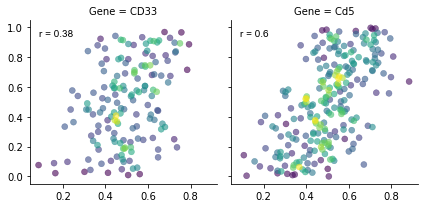

In [12]:
prediction_df = pd.DataFrame({'y_true': y_test,
                              'y_hat': predictions,
                              'Gene': tiling_data['Gene'][testing_indeces]})
g = sns.FacetGrid(data=prediction_df, col='Gene')
g.map_dataframe(gpplot.point_densityplot, x='y_hat', y='y_true')
g.map_dataframe(gpplot.add_correlation, x='y_hat', y='y_true',
                color='black')

### Model interpretation

You can use the python package [shap](https://shap.readthedocs.io/en/latest/)
to extract the importance of each feature in the trained model.

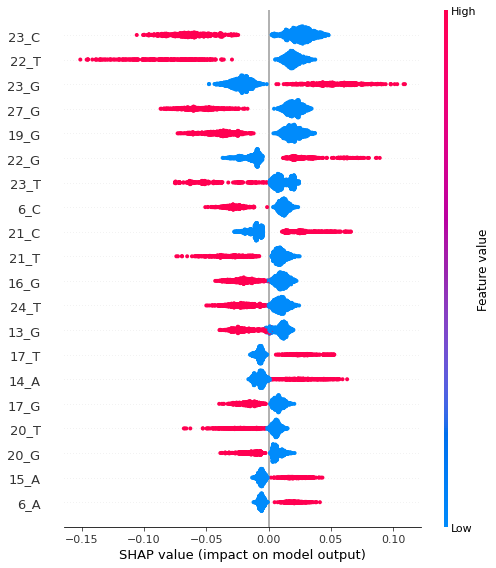

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

You can see that sgRNAs that have a C in the final guide position (position 23 in a 0-indexed context sequence)
tend to have lower activity.

## More resources

If you're interested in gaining a more comprehensive understanding of machine learning below are some good
resources:

1. Scikit-learn's [user guide](https://scikit-learn.org/stable/user_guide.html)
2. An Introduction to Statistical Learning with Application in R ([textbook](https://www.statlearning.com/))
3. Hands-on Machine Learning with Sikit-Learn, Keras & Tensorflow ([github](https://github.com/ageron/handson-ml2))
4. Practical Deep Learning for Coders ([course](https://course.fast.ai/))

Finally, building machine learning models using your own data is a great way to learn.